<a href="https://colab.research.google.com/github/Darwin575/CSE422_Courseworks/blob/main/lab_act6_lariosa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Initial Setup and Data Loading

### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

### **2. Data Loading and Initial Exploration**

In [ ]:

data = pd.read_csv('/content/sample_data/healthcare_dataset.csv')

# Display the first few rows
data.head()


,patient_id,Age,BMI,BloodPressure,Cholesterol,GlucoseLevel,HeartRate,SmokingHistory,ExerciseFrequency,HasDisease
0,pid7698,57.0,28.9,91.0,High,80.0,78.0,Never,High,0.0
1,pid8357,47.0,22.2,107.0,Normal,93.0,71.0,Never,NaN,0.0
2,pid3321,59.0,20.9,113.0,Normal,79.0,82.0,Never,NaN,0.0
3,pid4018,72.0,25.0,148.0,Normal,100.0,65.0,Never,Moderate,0.0
4,pid8521,46.0,24.1,128.0,Normal,88.0,75.0,Never,Low,1.0


### **3. Outlier Detection and Handling**
#### **Method Used:** Interquartile Range (IQR) Method
#### **Visualization:** Boxplots using Matplotlib and Seaborn

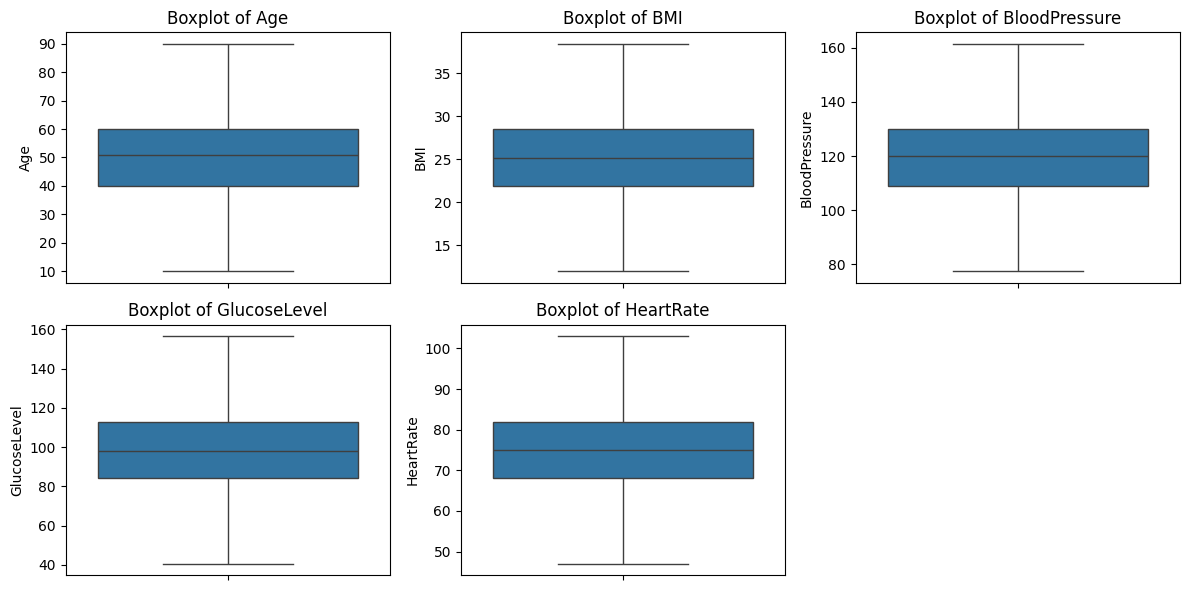

In [ ]:
# Separate numeric and categorical columns
numeric_cols = ['Age', 'BMI', 'BloodPressure', 'GlucoseLevel', 'HeartRate']
categorical_cols = ['Cholesterol', 'SmokingHistory', 'ExerciseFrequency']

# Function to cap outliers using IQR
def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply outlier capping to numeric features
data = cap_outliers(data, numeric_cols)

# Visualize the effect of outlier treatment
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

### **4. Categorical Data Encoding**
#### **Method Used:** Label Encoding

### **5. Handling Missing Data**
#### **Method Used:** K-Nearest Neighbors (KNN) Imputation

In [ ]:
# Label encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # Ensure all values are strings
    label_encoders[col] = le

# Drop rows where HasDisease is missing
data = data.dropna(subset=['HasDisease'])

# Apply KNN Imputer to all features
knn_imputer = KNNImputer(n_neighbors=5)
data_imputed = knn_imputer.fit_transform(data.drop(columns=['patient_id', 'HasDisease']))

# Round imputed categorical features back to integers
data_imputed[:, len(numeric_cols):] = np.round(data_imputed[:, len(numeric_cols):])

# Reconstruct the DataFrame
data_imputed = pd.DataFrame(data_imputed, columns=numeric_cols + categorical_cols)

# Add the target variable back
data_imputed['HasDisease'] = data['HasDisease'].values

# Verify if there are any remaining missing values
print(data_imputed.isnull().sum())

Age                  0
BMI                  0
BloodPressure        0
GlucoseLevel         0
HeartRate            0
Cholesterol          0
SmokingHistory       0
ExerciseFrequency    0
HasDisease           0
dtype: int64


### **6. Feature Selection**

In [ ]:
# Drop irrelevant columns (e.g., patient_id) if necessary
data_imputed.drop(columns=['patient_id'], inplace=True, errors='ignore')

# Select all features except the target variable
X = data_imputed.drop(columns=['HasDisease'])
y = data_imputed['HasDisease']

### **7. Data Splitting**
#### **Method Used:** Train-Test Split (80%-20%)

In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1140, 8)
Testing set size: (285, 8)


### **8. Feature Scaling**
#### **Method Used:** StandardScaler

In [ ]:
# Scale numeric features using StandardScaler
scaler = StandardScaler()

# Apply scaling only to numeric columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Verify scaling
print(pd.DataFrame(X_train_scaled, columns=X.columns).describe())

                Age           BMI  BloodPressure  GlucoseLevel     HeartRate  \
count  1.140000e+03  1.140000e+03   1.140000e+03  1.140000e+03  1.140000e+03   
mean  -5.609548e-17 -3.552714e-16   1.324477e-16  1.153074e-16  1.246566e-17   
std    1.000439e+00  1.000439e+00   1.000439e+00  1.000439e+00  1.000439e+00   
min   -2.691155e+00 -2.616605e+00  -2.724954e+00 -1.677228e+00 -2.835183e+00   
25%   -7.157706e-01 -6.428150e-01  -6.969945e-01 -5.336634e-01 -6.712239e-01   
50%    8.536894e-03 -3.488761e-02   1.118173e-02  6.099010e-01 -2.446771e-02   
75%    6.011521e-01  6.204107e-01   5.905986e-01  6.099010e-01  6.903681e-01   
max    2.576536e+00  2.594201e+00   2.682937e+00  1.753465e+00  2.805698e+00   

       Cholesterol  SmokingHistory  ExerciseFrequency  
count   1140.00000     1140.000000        1140.000000  
mean      74.70614        1.442982           1.588596  
std       10.07542        0.863510           1.070004  
min       47.00000        0.000000           0.000000  

### **9. Handling Class Imbalance**
#### **Method Used:** SMOTE-ENN (Synthetic Minority Over-sampling Technique and Edited Nearest Neighbors)

In [ ]:
# Apply SMOTE-ENN to balance the training data
smote_enn = SMOTEENN(random_state=42, sampling_strategy=0.6)  # Balance classes to equal sizes
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

# Check the new class distribution
print("Class Distribution After SMOTE-ENN:")
print(y_train_resampled.value_counts(normalize=True))

Class Distribution After SMOTE-ENN:
HasDisease
0.0    0.680645
1.0    0.319355
Name: proportion, dtype: float64


### **10. Neural Network Model**
#### **Architecture:**
- **Input Layer:** Accepts scaled numerical and encoded categorical features.
- **Hidden Layers:**
  - Dense layer with 32 neurons and Leaky ReLU activation.
  - Dropout layer (20%) to prevent overfitting.
  - Dense layer with 16 neurons and Leaky ReLU activation.
- **Output Layer:** Single neuron with sigmoid activation for binary classification.

In [ ]:
# Neural network architecture
model = Sequential([
    Dense(32, activation='leaky_relu', input_shape=(X_train_resampled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='leaky_relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,

)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4483 - loss: 2.5463 - val_accuracy: 0.0000e+00 - val_loss: 2.6717
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6575 - loss: 1.6098 - val_accuracy: 0.0000e+00 - val_loss: 5.7995
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7580 - loss: 1.2546 - val_accuracy: 0.0000e+00 - val_loss: 6.5901
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8190 - loss: 0.9513 - val_accuracy: 0.0000e+00 - val_loss: 6.1328
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7658 - loss: 1.3502 - val_accuracy: 0.0000e+00 - val_loss: 5.5109
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7694 - loss: 1.0929 - val_accuracy: 0.0000e+00 - val_loss: 5.0280
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7611 - loss: 1.3189 - val_accuracy: 0.0000e+00 - val_loss: 4.7096
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7341 - loss: 1.2215 - val_accuracy

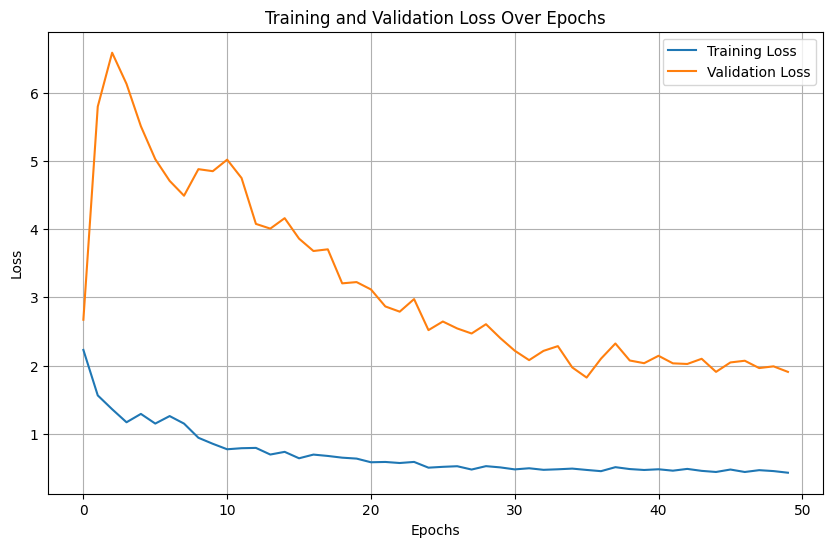

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### **11. Model Evaluation**
#### **Method Used:** Confusion Matrix & Classification Report

  - **Confusion Matrix:** Provides insight into model predictions (true positives, false positives, etc.).
  - **Classification Report:** Displays precision, recall, and F1-score, crucial for evaluating classification performance.

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


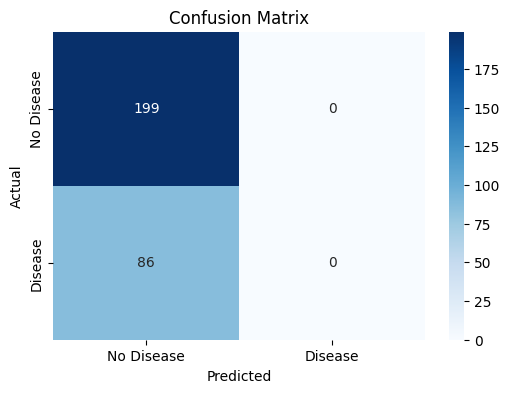

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      1.00      0.82       199
         1.0       0.00      0.00      0.00        86

    accuracy                           0.70       285
   macro avg       0.35      0.50      0.41       285
weighted avg       0.49      0.70      0.57       285



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Predictions with adjusted threshold
threshold = 0.4
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > threshold).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
